<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
<br>汉化的库: <a href="https://github.com/GoatCsu/CN-LLMs-from-scratch.git">https://github.com/GoatCsu/CN-LLMs-from-scratch.git</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="../image/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第五章: 在无标签数据集上预训练

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")
#同样导入库并检查版本

matplotlib version: 3.10.8
numpy version: 1.26.4
tiktoken version: 0.12.0
torch version: 2.10.0
tensorflow version: 2.20.0


- 在本章中，我们将实现循环训练和基本模型评价的代码，用于预训练大语言模型。
- 在本章的最后，我们还将从 OpenAI 加载公开可用的预训练权重到我们的模型中。

<img src="../image/chapter-overview.webp" width=500px>

- 本章节涉及的主题如下所示

<img src="../image/mental-model--0.webp" width=400px>

## 5.1 评估文本生成大模型

- 本节开始时，我们简要回顾了如何使用上一章的代码初始化 GPT 模型。
- 然后，我们讨论了大语言模型的基本评估指标。
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集。

### 5.1.1 用GPT来生成文本

- 我们首先与前几章一样初始化GPT

In [2]:
# 导入 PyTorch 库,用于构建和训练神经网络
import torch
# 从前面章节的代码中导入 GPTModel 类(在 previous_chapters 模块中定义)
from previous_chapters import GPTModel

# 定义 GPT-2 124M(1.24亿参数)模型的配置字典
# 这个配置决定了模型的架构和规模
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小:GPT-2 使用的 BPE 词汇表包含 50257 个 token
    "context_length": 256, # 上下文长度(最大序列长度):为了节省计算资源缩短为 256(原始 GPT-2 为 1024)
    "emb_dim": 768,        # 嵌入维度:每个 token 的向量表示维度,也是模型的隐藏层维度
    "n_heads": 12,         # 注意力头数量:多头注意力机制中的头数(emb_dim 必须能被 n_heads 整除)
    "n_layers": 12,        # Transformer 层数:模型堆叠的 Transformer 块数量
    "drop_rate": 0.1,      # Dropout 比率:训练时随机丢弃神经元的比例,用于防止过拟合(现代 LLM 通常不用)
    "qkv_bias": False      # Query-Key-Value 偏置:是否在注意力机制的 QKV 线性层中使用偏置项(现代 LLM 通常设为 False)
}

# 设置 PyTorch 的随机种子为 123,确保模型初始化的权重可复现
# 这样每次运行代码时,模型的初始参数都是相同的,便于调试和对比实验
torch.manual_seed(123)

# 使用上面定义的配置字典实例化 GPT 模型
# GPTModel 会根据配置创建包含嵌入层、多个 Transformer 块和输出层的完整模型
model = GPTModel(GPT_CONFIG_124M)

# 将模型设置为评估模式(evaluation mode)
# 这会禁用 Dropout 和 BatchNorm 等训练时特有的行为,确保推理时的确定性输出
model.eval();  # 注意:分号是为了在 Jupyter 中抑制输出
# 总结:导入模型类,设定模型架构参数,设定随机种子确保可复现,并初始化为评估模式

- 我们在上述代码中使用了 0.1 的 dropout 率，但如今训练大语言模型时通常不使用 dropout。
- 现代的大语言模型不在 `nn.Linear` 层的查询、键和值矩阵中使用偏置向量（与早期的 GPT 模型不同），而是通过设置 `"qkv_bias": False` 实现。
- 我们将上下文长度（`context_length`）减少到仅 256 个 token，以减少训练模型时的计算资源需求，而原始的 1.24 亿参数的 GPT-2 模型使用了 1024 个token。
  - 这是为了让更多读者可以在他们的笔记本电脑上运行并跟随代码示例。
  - 然而，您可以自由将 `context_length` 增加到 1024 个 token（这不需要更改任何代码）。
  - 我们稍后也将从预训练权重中加载一个具有 1024 `context_length` 的模型。

- 接下来，我们使用上一章中的 `generate_text_simple` 函数生成文本。
- 此外，我们定义了两个便利函数，`text_to_token_ids` 和 `token_ids_to_text`，用于在 token ID 和文本表示之间进行转换，这两个函数将在本章中多次使用。

<img src="../image/gpt-process.webp" width=500px>

In [3]:
import tiktoken  # 导入 tiktoken 作为 GPT-2 的分词器(BPE tokenizer)实现
from previous_chapters import generate_text_simple  # 导入上一章实现的简易文本生成函数

def text_to_token_ids(text, tokenizer):
    """
    将字符串文本转换为模型可接受的 token ID 张量。
    Args:
        text (str): 输入文本，例如 "hello world"
        tokenizer: 分词器对象(tiktoken)，用于编码字符串为 token ids
    Returns:
        Tensor: 形状为 [1, seq_len] 的 Long Tensor，作为模型的输入（包含 batch 维度）
    """
    # allowed_special={'<|endoftext|>'} 允许编码时捕获 GPT 特殊终止符（更完整地模拟 GPT-2 的处理方式）
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    # 转为 tensor，并增加 batch 维度（模型输入形状需为 [B, T]）
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # unsqueeze(0) 在最前面加一维
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    """
    将 token ID 张量还原为对应的字符串文本。
    Args:
        token_ids (Tensor): [1, seq_len] 或 [seq_len] 形状的 token id 张量
        tokenizer: 分词器对象(tiktoken)，用于将 token ids 解码为字符串
    Returns:
        str: 解码后的自然语言文本
    """
    # squeeze(0) 移除 batch 维度 [1, T] -> [T]，得到一维 token id 列表
    flat = token_ids.squeeze(0)
    # 解码为字符串文本
    return tokenizer.decode(flat.tolist())

# 示例起始上下文
start_context = "Every effort moves you"

# 实例化 GPT-2 的分词器 (BPE)；"gpt2" 标识选择与官方模型一致的词表和规则
tokenizer = tiktoken.get_encoding("gpt2")  # tiktoken 官方 推荐 API

# 用 generate_text_simple 生成新的 token id 序列
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),  # 初始 token id 张量(含 batch 维度)
    max_new_tokens=10,                                # 限定最多自动生成 10 个新 token
    context_size=GPT_CONFIG_124M["context_length"]     # 指定模型当前支持的最大上下文序列长度
)

# 将模型输出的 token id 张量反解码为人类可读的文本并输出
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所示，由于模型尚未训练，它生成的文本并不理想。
- 我们如何衡量或设定“好文本”的标准，并将其转化为数值，以便在训练过程中进行跟踪？
- 下一小节介绍了计算生成输出的损失指标的度量标准，我们可以用它来衡量训练进度。
- 后续关于微调大语言模型的章节还将介绍其他衡量模型质量的方法。

### 5.1.2 计算文本生成的损失：交叉熵(cross- entropy)和困惑度(perplexity)

- 假设我们有一个 `inputs` 张量，其中包含 2 个训练示例（行）的 token ID。
- 与 `inputs` 对应，`targets` 包含我们希望模型生成的目标 token ID。
- 请注意，`targets` 是将 `inputs` 向右移动 1 个位置后的结果，正如我们在第二章实现数据加载器时所解释的那样。

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]
#用向量的形式展现输入的文本
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]
#用向量的形式展现要输出的东西

- 将 `inputs` 输入给模型后，我们将得到 2 个输入示例的 logits 向量，每个输入示例包含 3 个token。
- 每个 token 都是一个 50,257 维的向量，对应于词汇表的大小。
- 通过应用 softmax 函数，我们可以将 logits 张量转换为一个相同维度的张量，其中包含概率得分。

In [5]:
# 在计算 logits 时，我们不需要进行梯度反向传播，因此使用 torch.no_grad() 来加速计算，并节省内存
with torch.no_grad():
    # 将输入输入进模型，获得每个 token 的输出 logits
    # logits 的维度为 (batch_size, num_tokens, vocab_size)
    # 其中 batch_size = 输入的样本数，num_tokens = 每条输入的 token 数量，vocab_size = 词表大小(50257)
    logits = model(inputs)

# 对 logits 的最后一维（词表维度）应用 softmax，得到属于词表中每个 token 的预测概率
# 结果 probas 的形状同 logits: (batch_size, num_tokens, vocab_size)
probas = torch.softmax(logits, dim=-1)  # 每个 token 在词表中每个词的概率分布

# 输出概率张量的形状，以便确认维度理解：应为 (批次数, token 数量, 词表大小)
print(probas.shape)  # 输出: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 下图展示了我们如何将概率得分转换为文本，示例使用了一个非常小的词汇表，这一内容已在上一章的结尾讨论过。

<img src="../image/proba-to-text.webp" width=500px>

- 如上一章所讨论的，我们可以应用 `argmax` 函数将概率得分转换为预测的 token ID。
- 上面的 softmax 函数为每个 token 生成了一个 50,257 维的向量；`argmax` 函数返回该向量中概率得分最高的位置，即给定 token 的预测 token ID。

- 由于我们有 2 个输入批次，每个批次包含 3 个 token，因此我们得到 2 行 3 列的预测 token ID：

In [6]:
# 使用 torch.argmax 在最后一个维度（即词表维度）上选取概率最大的位置，该位置对应于概率最高的 token 的词表索引（token ID）。
# keepdim=True 保持输出张量在该维度上的形状，以便后续处理时形状一致。
# 这一步相当于“贪心解码”：对每个输入文本的每个 token 位置，选择概率最高的 token，作为模型当前时刻的输出。
# 例如，对于批量输入为 (batch_size, num_tokens, vocab_size) 的 probas，
# 最终输出的 token_ids 是形状为 (batch_size, num_tokens, 1) 的张量。
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

# 打印出每个输入（batch）中每个 token 的预测 token ID（即词表索引）。
# 这些 token_ids 可以用于解码为对应的文本内容。
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果解码这些 token，我们会发现它们与希望模型预测的 token (目标 token)有很大不同：

In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
#给出答案
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
#给出事实上的结论

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还没有经过训练。
- 要训练模型，我们需要知道它与正确预测（目标）之间的差距有多大。

<img src="../image/proba-index.webp" width=500px>

- 对应于目标索引的 token 概率如下：

In [8]:
# 下面我们希望找出模型针对每个输入文本（batch）在每个 token 位置上，预测目标 token（targets）时给出的概率值
# 假设我们有 probas，其形状为 (2, 3, vocab_size)
# 其中，2 表示批大小（有2句话），3 表示每个句子3个 token，vocab_size 是词表大小

# 首先选择第一个 batch，对应 text 1
text_idx = 0  # 当前处理第一个输入文本（batch）
# probas[text_idx, [0, 1, 2], targets[text_idx]] 的意思是：
# - 取出第一个文本（batch）中的每个位置（token 0, 1, 2），
# - 对于每个位置，取出目标 token（targets[text_idx]）对应的概率（targets[text_idx] 形状为(3,)）
# 这样能得到该 batch 内每个 token 的目标概率
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
# 等价效果（逐位置取“正确目标 token”的概率）:
# target_probas_1 = torch.tensor([
#     probas[text_idx, 0, targets[text_idx][0]],
#     probas[text_idx, 1, targets[text_idx][1]],
#     probas[text_idx, 2, targets[text_idx][2]],
# ])
print("Text 1:", target_probas_1)  # 输出第一个输入文本每个 token 的“正确 token”概率值

# 同理，处理第二个 batch，对应 text 2
text_idx = 1  # 当前处理第二个输入文本（batch）
# 使用同样方式，取出第二个文本每个 token 的“正确 token”概率值
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)  # 输出第二个输入文本每个 token 的“正确 token”概率值

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化这些值，使它们的概率接近 1。
- 在数学优化中，最大化概率得分的对数比直接最大化概率得分更为简单；虽然这超出了本书的讨论范围，但我录制了一节更详细的讲座，您可以在这里查看：[L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)。

In [9]:
# 我们想要计算模型在两个输入文本（batch）上的每个 token，预测“正确目标 token”时给出的概率的对数值（log-probability）。
# 之前已经得到了 target_probas_1 和 target_probas_2，分别表示第1和第2个输入文本中每个 token 的目标概率（target token 的预测概率），shape 都是 (3,)

# 首先，将两个 batch 的目标概率拼接起来，得到一个长度为6的一维向量，表示所有 token 的目标概率。
all_target_probas = torch.cat((target_probas_1, target_probas_2))  # 拼接两个 batch 的目标概率，得到 shape=(6,)

# 接下来，对每个目标概率取对数，得到每个 token 的 log-probability（对数概率）。
# torch.log 作用是单元素取自然对数（ln），注意：概率越接近1，log值越接近0；概率越小，log值越负，表示模型信心不足。
log_probas = torch.log(all_target_probas)

# 打印结果，查看每个 token 的预测对数概率值。
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率：

In [10]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
#对数概率平均值

tensor(-10.7940)


- 目标是通过优化模型权重，使得平均对数概率尽可能大。
- 由于对数的性质，最大的可能值是 0，而我们当前距离 0 还有很大差距。

- 在深度学习中，通常的做法是最小化 "负" 的平均对数概率值，而不是最大化平均对数概率值；在我们的例子中，深度学习中我们会最小化 10.7722 使其接近 0，而不是最大化 -10.7722 使其接近 0。
- 值 -10.7722 的负数，即 10.7722，在深度学习中也被称为交叉熵损失（cross-entropy loss）。

In [11]:
neg_avg_log_probas = avg_log_probas * -1
#最大化对数等价为最小化负对数
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch 中的`cross_entropy` 已经能实现这些功能

<img src="../image/cross-entropy.webp" width=400px>

- 在使用`cross_entropy` 之前, 我们可以看一下loggias跟target是怎样的

In [12]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 有了PyTorch 中的 `cross_entropy` 函数，我们希望通过在批次维度上合并这些张量来将其展平：

In [13]:
logits_flat = logits.flatten(0, 1)
#将张量 logits 的 第0维和第1维合并为一个维度，展平成一个二维张量
targets_flat = targets.flatten()
#将张量 targets 展平为一维张量

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 请注意，目标是 token ID，这些 ID 也代表我们希望最大化的 logits 张量中的索引位置。
- PyTorch 中的 `cross_entropy` 函数会自动处理对这些token索引的 softmax 和对数概率计算，确保它们被最大化。

In [14]:
# 使用PyTorch的cross_entropy函数来计算交叉熵损失。
# 
# 参数说明：
# - logits_flat: 形状为 (batch_size * num_tokens, vocab_size) 的二维张量，表示模型输出的未归一化分数（logits），
#   其中每一行对应一个样本在整个词表上的预测分布。
# - targets_flat: 形状为 (batch_size * num_tokens,) 的一维张量，表示每个样本的真实类别（即目标token的索引）。
#
# 这个函数会自动对logits应用softmax，将其转换为概率分布，然后计算目标token的负对数概率（负对数似然）。
# 最终返回所有样本的平均损失值（标量）。
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

# 输出计算得到的平均交叉熵损失。
# 该值通常用作神经网络训练时的优化目标，数值越小代表模型性能越好。
print(loss)

tensor(10.7940)


- 与交叉熵损失相关的一个概念是大语言模型的困惑度 (perplexity)。
- 困惑度就是交叉熵损失的指数值。

In [15]:
perplexity = torch.exp(loss)
#指数化loss作为P值
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更易解释，因为它可以理解为模型在每一步对词汇表大小的不确定性（在上面的例子中，这相当于 48,725 个单词或 token）。
- 换句话说，困惑度提供了一个衡量模型预测的概率分布与数据集中单词实际分布匹配程度的指标。
- 类似于损失值，较低的困惑度表示模型预测与实际分布的差距较小。

### 5.1.3 计算训练集和验证集的损失

- 我们使用一个相对较小的数据集来训练大语言模型（训练内容只有一个短篇故事）。
- 选择小故事的原因包括：
  - 无独立显卡的电脑也可以快速完成
  - 训练时间较短（以分钟计算，而非数周）
  - 我们使用了无版权文本，可以将其包含在这个 GitHub 仓库中，而不会违反任何使用权或显著增加仓库大小。

- 例如，Llama 2 7B 模型在 2 万亿 token 上训练时需要 184,320 个 GPU 小时（使用 A100 GPU）。
  - 截至本文撰写时，AWS 上 8xA100 云服务器的每小时成本约为 30 美元。
  - 因此，通过简单计算，训练这个 LLM 的成本为 184,320 / 8 * 30 美元 = 690,000 美元。

- 下面，我们使用了第二章中使用的同一数据集。

In [16]:
import os  # 导入操作系统相关功能的模块，用于检查文件是否存在
import urllib.request  # 导入用于处理URL操作的模块，用于从网络下载文件

# 设置本地数据集文件的路径
file_path = "the-verdict.txt"

# 提供远程数据集的URL地址，若本地没有则从该地址下载
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# 检查本地是否已经存在目标数据集文件，以避免重复下载
if not os.path.exists(file_path):
    # 本地文件不存在，从指定URL下载数据
    with urllib.request.urlopen(url) as response:
        # 读取网络应答内容，并以utf-8编码解码为字符串
        text_data = response.read().decode('utf-8')
    # 将下载获得的数据写入本地文件，便于后续再次使用时无需重新下载
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    # 如果本地文件已存在，则直接从本地读取内容，加快处理速度
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

# 到这里，无论是下载还是本地读取，我们都得到了完整的数据集内容，存储在text_data变量中

- 通过前100个词与后100个词快速检查文本是否加载正常

In [17]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [18]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
#统计一下文本的长度,编码文本内容并输出文本个数
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 为了教学,我们选取了这个短文本作为样例

- 接下来，我们将数据集划分为训练集和验证集，并使用第二章中的data loader为大语言模型（LLM）训练准备数据。
- 出于可视化的目的，下图假设 `max_length=6`，但对于训练加载器，我们将 `max_length` 设置为 LLM 支持的上下文长度。
- 为了简化，下图仅展示了输入token：
    - 由于我们训练 LLM 预测文本中的下一个单词，因此目标 token 与输入 token 相同，只是目标 token 向右移动了一个位置。

<img src="../image/batching.webp" width=500px>

In [20]:
from previous_chapters import create_dataloader_v1  # 导入之前章节自定义的数据加载器函数 create_dataloader_v1

# 训练集和验证集的比例（90% 训练集, 10% 验证集）
train_ratio = 0.90  # 通常机器学习任务会将大部分样本用于训练
split_idx = int(train_ratio * len(text_data))  # 计算用于分割数据集的索引

# 根据上述索引，将整个文本数据拆分为训练集和验证集
train_data = text_data[:split_idx]  # 前90%作为训练集
val_data = text_data[split_idx:]    # 后10%作为验证集

# 设置随机种子，确保实验可复现（同样的数据集和参数下每次运行结果一致）
torch.manual_seed(123)

# 构建训练数据加载器
# - train_data: 分割后的训练文本
# - batch_size=2: 每个批次2组数据（便于代码测试和调试，小批量可加快实验迭代）
# - max_length：单个输入序列的最大长度，设为GPT配置中的context_length
# - stride：窗口滑动步幅，此处等同于max_length，即无重叠滑动窗口
# - drop_last=True: 如果最后一个批次不足batch_size，则丢弃该批
# - shuffle=True：训练集需打乱，避免模型记住文本顺序，利于泛化
# - num_workers=0：加载数据时不使用多进程，加速作用在大数据集下更明显
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

# 构建验证数据加载器（与训练集不同点如下）
# - drop_last=False: 验证时希望用到全部数据，因此不丢弃最后一个不足batch的批次
# - shuffle=False: 验证时无需打乱数据，确保评估过程稳定一致
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [21]:
# Sanity check – 数据量充足性检查
# 目的：确认训练集（train_loader）和验证集（val_loader）里，是否都有足够token填满一个完整的序列（即至少够一个“窗口”）。
# 若不足，数据加载器会报错、空批次或训练毫无意义。
# 下面分别对训练和验证部分进行检查。

# 检查训练集：训练集的token总数（total_tokens * train_ratio）是否大于等于序列长度设定（context_length）
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          # 说明：训练数据不够，无法切分出一个完整序列
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          # 建议1：降低模型的context长度要求
          "increase the `training_ratio`")                # 建议2：提高训练集所占比例

# 检查验证集：验证集的token总数（total_tokens * (1-train_ratio)）是否同样充足
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          # 说明：验证数据同样不够填满一个批次
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          # 建议1：同样考虑降低context长度
          "decrease the `training_ratio`")                # 建议2：减少训练比例，让验证集有更多token

- 小的批处理数据集很适合用来小试牛刀
- 例如, Llama 27B就是用每次1024的批处理数据

- 另一种确认数据正常导入的方法如下

In [22]:
# 逐批次遍历训练数据加载器，打印每个输入（x）和目标（y）张量的形状
print("Train loader:")
for x, y in train_loader:
    # x: 输入序列的张量，shape: (batch_size, context_length)
    # y: 目标输出（通常是下一个token的标签），shape: (batch_size, context_length)
    print(x.shape, y.shape)

print("\nValidation loader:")
# 逐批次遍历验证数据加载器，检查每一批次数据是否形状一致
for x, y in val_loader:
    # 我们也打印val_loader中的每个批次输入与目标张量的形状，用于确认数据加载是否正确和与训练集的一致性
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 还有一个方法来确认是否导入成功

In [23]:
# 统计训练集的 token 总数
train_tokens = 0  # 用于累加训练集 token 数
for input_batch, target_batch in train_loader:
    # input_batch: 训练集输入张量，形状为 (batch_size, context_length)
    # .numel() 返回张量中所有元素的数量，即该 batch 包含的所有 token 数
    train_tokens += input_batch.numel()

# 统计验证集的 token 总数
val_tokens = 0  # 用于累加验证集 token 数
for input_batch, target_batch in val_loader:
    # 同理，累计每个 batch 的 token 数
    val_tokens += input_batch.numel()

# 打印训练集、验证集和总 token 数
print("Training tokens:", train_tokens)    # 输出训练集所有批次的总 token 数
print("Validation tokens:", val_tokens)    # 输出验证集所有批次的总 token 数
print("All tokens:", train_tokens + val_tokens)  # 输出训练+验证集 token 总和

# 说明：
# - 在 PyTorch 中，.numel() 方法返回张量所有元素（token）的总数，无论其实际维度如何。
# - 这样可以粗略统计 token 数，以判断数据划分和加载是否符合预期。

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 我们用了预分装函数来计算交叉熵
- 我们还调用另一个辅助函数，用于计算数据加载器中由用户指定的批次数Loss。

In [24]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # 将输入与目标张量移动到指定的计算设备上（如 GPU 或 CPU）
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # 前向传播：用模型计算输入batch的logits（预测结果，shape: [batch_size, context_length, vocab_size]）
    logits = model(input_batch)
    # 由于 PyTorch 的 Cross Entropy Loss 期望输入为二维（[N, C]）和一维（[N]）张量，这里需要 flatten
    # logits.flatten(0, 1): 将[batch_size, context_length, vocab_size]拉平成[batch_size*context_length, vocab_size]
    # target_batch.flatten(): 将目标也拉成一维（[batch_size*context_length]），表示每个位置的真实词id
    # 计算批次的交叉熵损失
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    # 返回单个批次的loss张量
    return loss
# 说明：此函数对一个batch的数据，计算模型输出与真实标签之间的交叉熵损失，常用于训练和评估。

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    遍历整个dataloader（或部分指定的批次），累加每个batch的loss，最后返回平均损失。
    - data_loader: 数据加载器
    - model: 当前模型
    - device: 计算设备
    - num_batches: 可选，若指定，则仅计算前num_batches个batch
    """
    total_loss = 0.  # 用于累加损失和
    if len(data_loader) == 0:
        # 防止空的数据加载器，直接返回nan
        return float("nan")
    elif num_batches is None:
        # 若未指定num_batches，则遍历整个数据加载器
        num_batches = len(data_loader)
    else:
        # 指定了num_batches，取用户指定和实际可用批次数的较小者，防止超出总批次数
        num_batches = min(num_batches, len(data_loader))
    # enumerate为每个batch编号和提供数据
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # 用上面函数分别计算每批次的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # 将 loss 张量转为 float 累加
        else:
            # 如果已经处理了指定批次数，则跳出循环
            break
    # 返回平均损失（总损失除以批次数）
    return total_loss / num_batches

- 如果你的电脑有支持 CUDA 的 GPU，大预言模型将无需更改代码即可在 GPU 上进行训练。
- 通过 `device` 设置，我们确保数据加载到与大语言模型相同的设备上。

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 如果支持，则调用 GPU

# 注意：
# 如果取消注释以下代码块，代码可以在 Apple Silicon 芯片上运行（如果适用），
# 在 M3 MacBook Air 上测量速度大约是 Apple CPU 的两倍。
# 然而，计算得到的损失值可能会略有不同。

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")

model.to(device)  # 对于 nn.Module 类，不需要赋值 model = model.to(device)

torch.manual_seed(123)  # 固定随机种子，保证数据加载器打乱数据的结果可复现

with torch.no_grad():  # 禁用梯度跟踪以提高效率，因为此时尚未开始训练
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

# 推理阶段不计算梯度
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.98110580444336


<img src="../image/mental-model-1.webp" width=400px>

## 5.2 训练大语言模型

- 在本节中，我们最终实现了用于训练大语言模型（LLM）的代码。
- 我们想要于一个简单的训练函数（如果您对通过更高级的技术增强此训练函数感兴趣，例如学习率预热(rate warmup)、余弦退火(cosine annealing)和梯度裁剪(gradient clipping)，请参阅[附录D](../../appendix-D/01_main-chapter-code)）。

<img src="../image/train-steps.webp" width=300px>

In [26]:
def train_model_simple(
    model,            # nn.Module 神经网络模型
    train_loader,     # 训练集 DataLoader（按 batch 提供数据）
    val_loader,       # 验证集 DataLoader
    optimizer,        # 优化器（如 AdamW）
    device,           # 设备，例如 "cpu"、"cuda" 或 "mps"
    num_epochs,       # 训练轮数（遍历整个训练集的次数）
    eval_freq,        # 评估间隔（每多少 step 评估一次）
    eval_iter,        # 每次评估时采样多少个 batch 计算损失
    start_context,    # 用于生成演示文本的初始提示（字符串）
    tokenizer         # 分词器（实现编码与解码）
):
    # 初始化三个列表，用于记录训练损失、验证损失、已见 token 数
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # 累计走过的 token 数和全局step编号

    # 主训练循环：epoch 表示“轮”（每轮遍历一遍全部训练集）
    for epoch in range(num_epochs):
        model.train()        # 设置为训练模式（例如启用 dropout/batchnorm）
        # 遍历当前 epoch 的所有 batch（每个 batch 是小批量的数据）
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   # 梯度清零，避免上一次累积
            # 前向传递 & 损失计算（input_batch: 输入 token，target_batch: 目标 token）
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()         # 误差反向传播：计算参数梯度
            optimizer.step()        # 执行一步优化：更新参数

            tokens_seen += input_batch.numel()  # 累加本 batch token 数（粗略统计训练了多少 token）
            global_step += 1                    # 每处理一个 batch，全局 step 增 1

            # 评估监控（每 eval_freq 步评估一次）
            if global_step % eval_freq == 0:
                # 在评估时调用 evaluate_model，返回训练集/验证集损失
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # 显示当前训练步的信息
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每个 epoch 结束后，生成一段示例文本, 直观了解模型效果
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    # 返回所有采样点处的损失
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # 用于在训练过程中“快照”评估模型的 train/val 损失
    model.eval()              # 切到 eval 模式（关闭 dropout/batchnorm）
    with torch.no_grad():     # 保证不计算梯度，提高效率，节约显存
        # 只取前 eval_iter 个 batch 做评估，加速（完整评估全量数据通常较慢）
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()             # 评估后，切回 train 模式（继续训练）
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    # 生成一段模型预测文本，并打印出来
    model.eval()  # 切到 eval 模式，保证一致性
    context_size = model.pos_emb.weight.shape[0]  # 上限长度（比如 128）
    encoded = text_to_token_ids(start_context, tokenizer).to(device)  # 编码起始文本为 token id
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,          # 每轮生成 50 个新 token
            context_size=context_size   # 上下文窗口长度
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)  # 解码为字符串
    print(decoded_text.replace("\n", " "))                  # 简洁打印（去掉换行）
    model.train()      # 恢复训练模式以便后续继续训练

(GPT的解释)
- global_step 是训练循环中的重要计数器，主要用于控制学习率调度、记录日志、保存模型检查点和控制终止条件等任务。
- 在分批训练中，它提供了一个统一的参考点，有助于管理复杂的训练流程。
- epoch 是按完整数据集的迭代单位，而 global_step 是按 batch 单位，粒度更细，用于管理更精确的任务。例如：
    1.	动态学习率调整,某些学习率调度器需要以 batch 为单位进行调整，而不是每个 epoch。例如，WarmUp 会在固定的前 N 步逐渐升高学习率。
	2.	频繁日志记录,记录训练日志时，通常是每隔 log_interval 步输出一次，而不是每个 epoch。
	3.	检查点保存,保存模型状态通常是按步数完成，尤其是当训练需要中断和恢复时，global_step 是更精确的 token。

- 我们用上述的定义训练一下这个模型

In [27]:
# Note:
# 本段代码用于训练一个 GPT 模型，并测量整个训练过程的耗时
import time   # 导入 time 库用于计时

start_time = time.time()  # 记录训练开始的时间，单位为秒

torch.manual_seed(123)    # 设置随机种子，保证实验的可复现性

# 实例化 GPT 小模型。GPT_CONFIG_124M 是预定义的模型配置（如层数/头数等）
model = GPTModel(GPT_CONFIG_124M)
model.to(device)          # 将模型加载到指定设备（如 GPU 或 CPU）

# 设置优化器：采用 AdamW 优化算法
# - lr=0.0004：学习率，表示每次参数更新的步幅大小
# - weight_decay=0.1：权重衰减（L2 正则化），有助于防止过拟合
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10  # 计划训练的总轮数（每轮遍历一次全部训练集）

# 启动训练流程
# - train_loader: 训练数据加载器
# - val_loader: 验证数据加载器
# - optimizer: 优化器对象
# - device: 计算设备
# - num_epochs: 总训练轮数
# - eval_freq: 每隔多少步评估并记录一次当前最新损失
# - eval_iter: 评估时包含的 batch 数量（加速评估）
# - start_context: 用于生成样例时的起始文本
# - tokenizer: 分词器/编码器
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
# train_losses/val_losses: 记录每个评估点训练和验证损失（loss），通常用于后续画图
# tokens_seen: 记录到当前评估点为止模型见过多少个 token（累计训练的进度指标）

end_time = time.time()  # 训练结束，记录当前时间
execution_time_minutes = (end_time - start_time) / 60  # 计算训练耗时，单位转换为分钟
print(f"训练完成耗时 {execution_time_minutes:.2f} 分钟。")  # 输出总训练时间

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.600
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.586, Val loss 6.477
Ep 3 (Step 000025): Train loss 5.523, Val loss 6.399
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.128, Val loss 6.366
Ep 4 (Step 000035): Train loss 4.941, Val loss 6.366
Every effort moves you a a to the a. Gisburn, and a. Gisburn. I had the of the of the of the of the of the of the of the of the of the of the of the of the of the. I had a
Ep 5 (Step 000040): Train loss 4.340, Val loss 6.246
Every effort moves you, with a, in the of the pi

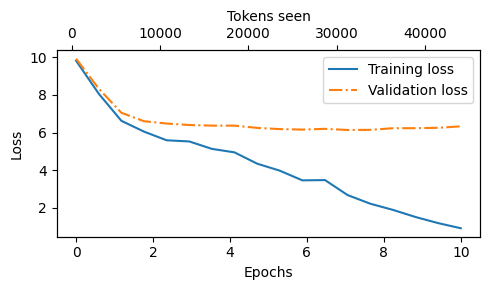

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 画 loss 曲线的函数（更详细注释版）
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    # 创建一个新的图像（fig），和主坐标轴（ax1）；设置图像大小为5x3英寸
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 在主坐标轴上绘制训练损失曲线
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    # 绘制验证集损失曲线，使用不同线型区分
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")  # 横坐标为“轮数（Epochs）”
    ax1.set_ylabel("Loss")    # 纵坐标为“损失值”
    ax1.legend(loc="upper right")  # 图例放在右上角
    # 让主横坐标（Epochs）只显示整数刻度，比如 0, 1, 2, ...，避免非整数的小数刻度
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # 创建一个共享相同纵坐标(y) 的第二横坐标轴（ax2）
    ax2 = ax1.twiny()  # twiny: 在顶部叠加一个新的x轴
    # 为了让 ax2 的 x 轴与 tokens_seen 刻度保持一致，这里画一条不可见的直线（alpha=0），
    # 这样 ax2 的横坐标会自动适配 tokens_seen 区间
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")  # 顶部横坐标名为“已见 token 数”

    # 自动调整图像布局，使元素不重叠
    fig.tight_layout()
    # 保存图片到文件，文件名为 loss-plot.pdf（可用于论文/汇报插图）
    plt.savefig("loss-plot.pdf")
    # 显示图像
    plt.show()

# 构建 epochs_tensor，形状与 losses 相匹配，用于横坐标（轮数）对齐平滑绘图
# torch.linspace(start, end, steps)：在 start 和 end 之间均匀生成 steps 个点
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# 调用上面的 plot_losses 函数，画出训练集和验证集loss曲线以及 token 进度
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
# 这是一个很常见的画 loss 曲线函数的范例，适合任何深度学习任务

- 从以上结果可以看出，模型在开始阶段生成的是难以理解的字符串，但是在后期能够生成基本符合语法的句子。
- 从训练集和验证集的损失值可以看出，模型开始出现过拟合现象。
- 如果检查后期它生成的某些段落，会发现它们与训练集中的内容完全相同(模型只是简单地记住了训练数据,背住答案罢了)。
- 之后的部分，我们将讨论一些解码策略，这些策略可以一定程度缓解这种“背答案”的问题。
- 请注意，这里的过拟合是由于训练集非常非常小，并且我们对其进行了多次迭代。
  - 本次 LLM 训练主要用于教学目的；我们的目标是观察模型是否能够学会生成连贯的文本。
  - 为了避免花费数周或数月时间在大量昂贵硬件上训练模型，我们将在后续加载预训练权重。

<img src="../image/mental-model-2.webp" width=350px>

**如果您对通过更高深的技术增强此训练函数感兴趣，例如学习率预热、余弦退火和梯度裁剪，请参阅[附录D](../../appendix-D/01_main-chapter-code)。**

**更大的数据集跟更深度的训练,可以在以下找到链接 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 控制随机性的解码策略

- 对于像我们训练的这种规模相对较小的GPT模型（LLM），推理阶段的计算成本较低。因此，如果在训练时使用了GPU，推理阶段则无需依赖GPU资源。
- 我们可以利用第5章介绍的`generate_text_simple`函数（该函数已在简单训练函数中被调用）来逐步生成新文本，每次生成一个单词（或 token）。
- 正如5.1.2节所提到的，下一个生成的 token 是从词汇表中选取概率得分最高的 token 。

In [29]:
# 将模型参数从GPU（如果原本在GPU）转移到CPU上，方便后续推理和节省资源
model.to("cpu")
# 设置模型为推理（evaluation）模式，关闭dropout、batchnorm等随机性，用于生成阶段
model.eval()

# 加载GPT-2的分词器，本例用tiktoken库，tokenizer用于文本与token id的相互转换
tokenizer = tiktoken.get_encoding("gpt2")

# 利用 generate_text_simple 函数生成新文本（自动文本补全）
# 参数说明：
# - model: 训练好的GPT模型
# - idx: (张量) 输入文本的token id序列，作为生成起点（prompt）
# - max_new_tokens: 生成新token的最大数目（此例生成25个新token）
# - context_size: 每次前馈生成所允许的最大上下文长度（与模型结构相关）
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),  # 将输入字符串转为token id列表
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

# 输出：打印模型生成的文本（将token id序列解码为字符串）
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- 即使我们多次调用 `generate_text_simple` 函数，大语言模型（LLM）生成的输出也始终是确定性的，即每次结果相同。
- 为了增强生成文本的灵活性，我们引入了两种解码策略来改进 `generate_text_simple`：**温度缩放** 和 **top-k 采样**。
- 这些方法能够调节模型生成文本的随机性和多样性，从而满足不同的应用需求。

### 5.3.1 温度缩放

- 在之前的实现中，我们始终使用 `torch.argmax` 来选择概率最高的 token 作为下一个生成的 token。
- 为了增加生成文本的多样性，我们可以改用 `torch.multinomial(probs, num_samples=1)`，从概率分布中随机采样下一个 token。
- 在这种方法中，每个索引被选中的概率与其在输入张量中对应的概率值成正比，从而实现基于概率的随机采样。

- 以下是对生成下一个 token 过程的简单回顾，假设我们使用一个非常小的词汇表来说明：

In [30]:
# 构造一个小型词表，方便举例说明每个token对应的ID
vocab = { 
    "closer": 0,    # "closer" 对应的 token id 是 0
    "every": 1,     # "every"  对应的 token id 是 1
    "effort": 2,    # 以下依此类推
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

# 反向词表：根据token id查回原始单词，便于查看输出结果
inverse_vocab = {v: k for k, v in vocab.items()}

# 假设当前输入序列为 "every effort moves you"，
# 经过 LLM 预测，下一个 token 的所有候选项得到如下 logits（未归一化分数，高者代表模型更偏好）
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
# token 顺序与 vocab 上述顺序对应。例如4.51代表"closer"，6.75代表"forward"

# 第一步：将 logits 转换为概率分布（概率越大，模型越倾向于选该token）
probas = torch.softmax(next_token_logits, dim=0) # 对所有logits做softmax归一化

# 第二步：选择概率最大的 token 作为输出（贪心解码/确定性采样）
next_token_id = torch.argmax(probas).item()      # 取得概率值最大的token对应的id

# 输出下一个 token（通过 token id 查回单词），观察模型会“接”什么词
print(inverse_vocab[next_token_id])   # 打印生成的下一个单词

forward


In [31]:
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [32]:
# 设置随机种子，使每次采样都可以复现同样的结果（便于调试和教学说明）
torch.manual_seed(123)

# 从概率分布 probas 中“随机”采样一个 token 的 id
# torch.multinomial 会根据每个token的概率值进行加权随机选择，其中被选中的token概率越大，越容易被采样到
# 参数说明：
#   - probas: 各token的归一化概率分布（softmax输出）
#   - num_samples=1: 只采样1个token
# 返回结果是一个长度为1的张量，.item()取出其中的整数值（就是token的id）
next_token_id = torch.multinomial(probas, num_samples=1).item()

# 将采样得到的 token id 转换为原始单词。inverse_vocab用来查表映射
print(inverse_vocab[next_token_id])

forward


- 我们不再依赖 `torch.argmax` 来选择最可能的 token ，而是通过 `torch.multinomial(probas, num_samples=1)` 从 softmax 分布中采样来确定下一个 token 。
- 为了直观地理解这一过程，我们可以使用原始的 softmax 概率对下一个 token 进行 1,000 次采样，并观察结果分布：

In [33]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    #从概率分布 probas 中按照权重进行一次采样,并生成索引
    sampled_ids = torch.bincount(torch.tensor(sample))
    #然后变成单词
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
#统计采样过程中每个词的出现频率
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


- 我们可以通过一种称为**温度缩放**的技术来调节概率分布和 token 选择的过程。
- 温度缩放的核心操作是将 logits 除以一个大于 0 的数值（即温度值），然后再应用 softmax 函数。
- 当温度值大于 1 时，softmax 输出的概率分布会更加均匀，从而增加生成文本的多样性。
- 当温度值小于 1 时，softmax 输出的概率分布会更加集中（更陡峭或更尖锐），从而倾向于选择概率更高的 token，减少随机性。

模型的预测概率往往过于自信或低估某些类别的概率，尤其在分类任务中。
温度缩放通过引入一个参数  T > 0  来重新调整 logits，改善预测概率的校准性能

In [34]:
def softmax_with_temperature(logits, temperature):
    """
    对 logits 向量执行温度缩放后的 softmax：
    - logits: 原始未归一化的模型输出（通常是每个 token 的分数）
    - temperature: 温度系数，调节分布的“平坦”程度
      - temperature > 1：分布更平坦，更加多样化，不同token概率差距变小（增加随机性）
      - temperature < 1：分布更尖锐，概率大的token更突出（趋向贪婪/确定性采样）
      - temperature = 1：标准 softmax（无缩放）
    """
    scaled_logits = logits / temperature  # 将 logits 除以温度参数（核心操作）
    return torch.softmax(scaled_logits, dim=0)  # 沿着 token 维度做 softmax，得到概率分布

# 设定多个温度系数用于实验不同采样策略的影响
# - 1   ：原始分布（无温度缩放，标准 softmax）
# - 0.1 ：低温度，使分布极其陡峭，几乎总是选最大概率的token
# - 5   ：高温度，使分布比较平坦，提升小概率token被采样到的机会
temperatures = [1, 0.1, 5]

# 针对每个温度系数，分别对 logits 计算经过温度缩放后的 softmax 概率分布
# 最终 scaled_probas 是一个列表，包含不同温度下的概率分布（每个元素 shape 与 logits 相同）
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

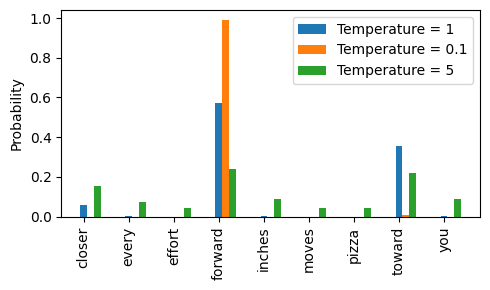

In [35]:
# ---- 绘制不同温度下 softmax 概率分布的条形图 ----

# x 轴位置：生成长度为 vocab 大小的等差数列 [0, 1, ..., len(vocab)-1]
x = torch.arange(len(vocab))

# 每组条形（bar）的宽度设置为 0.15，方便多组并排显示，避免重叠
bar_width = 0.15

# 创建一个图像和一个坐标轴对象，设置图像大小为 5x3 英寸
fig, ax = plt.subplots(figsize=(5, 3))

# 遍历每个温度参数，将不同温度下 softmax 概率分布绘制为并排条形图
for i, T in enumerate(temperatures):
    # ax.bar 的第一个参数是条形的起始 x 坐标：
    # - x + i * bar_width，把每组不同温度的条形错开并排
    # - scaled_probas[i] 是此温度下各 token 的概率，作为条形高度
    # - label 便于后续图例（legend）区分不同温度
    rects = ax.bar(
        x + i * bar_width,       # x 位置偏移，错位显示
        scaled_probas[i],        # 对应概率分布
        bar_width,               # 条形宽度
        label=f'Temperature = {T}'  # 图例标签
    )

# 设置 y 轴标签为“Probability”
ax.set_ylabel('Probability')

# 设置 x 轴刻度为 vocab 中所有 token 的索引位置
ax.set_xticks(x)

# 将 x 轴的刻度标签设置为 vocab 的单词（token），并旋转 90 度防止重叠
ax.set_xticklabels(vocab.keys(), rotation=90)

# 显示图例，区分每种温度下的分布
ax.legend()

# 自动调整子图参数，使内容布局更加紧凑，防止标签被遮挡
plt.tight_layout()

# 将图片保存为 PDF 文件，便于后续查看或文档引用
plt.savefig("temperature-plot.pdf")

# 显示最终绘制的图表
plt.show()

# 一套经典的 matplotlib 条形图绘制流程，此处用来直观比较不同温度下 softmax 概率分布的形态

- 从结果中可以看出，当温度设置为 0.1 时，概率分布变得更加陡峭，接近于 `torch.argmax` 的行为，因此最可能的 token 几乎总是被选中：

In [36]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward


- 当温度设置为 5 时，概率分布变得更加均匀，从而增加了生成文本的多样性和随机性：

In [37]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设大语言模型（LLM）的输入是“every effort moves you”，上述方法有时可能会生成无意义的文本，例如“every effort moves you pizza”，其出现的概率为 3.2%（即在 1000 次采样中出现了 32 次）。

### 5.3.2 Top-k 取样

- 为了在使用更高温度增加输出多样性的同时减少生成无意义句子的概率，我们可以将采样限制在前 k 个最可能的 token 中：

<img src="../image/topk.webp" width=500px>

- （请注意，此图中的数值已截取到小数点后两位，以减少视觉干扰。Softmax 行中的值总和应为 1.0。）

- 我们可以按照下述建议补充代码

-	控制输出质量： 减少低概率、无意义的词被选中的机会。
-	保持多样性： 允许模型在概率较高的几个候选词中随机选择，而不是总是选择最高概率的词（这会导致输出缺乏变化）。

In [38]:
# 设定 top_k 的值，这里我们选择只关注概率最高的前 3 个 token
top_k = 3

# 使用 torch.topk 函数，从 logits 中选出概率（logits 值）最大的前 top_k 个元素
# - top_logits: 代表前 top_k 个 logits（未经过 softmax，因此还不是概率，但大小关系仍然代表相对概率高低）
# - top_pos: 代表上述 top_k logits 所对应的 token 索引（即 vocabulary 里的具体 token 位置）
top_logits, top_pos = torch.topk(next_token_logits, top_k)

# 打印 top_k 的 logits 值（越大表示模型越倾向选择该 token）
print("Top logits:", top_logits)
# 打印 top_k logits 对应的 token 在 vocab 里的位置（可以用来进一步获取具体 token 字符串）
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [39]:
# 对 logits 分布利用 top-k 掩码，屏蔽掉不在前k名的 token，只保留 top_k 最高分的 token。
# 详细说明如下：
# - torch.where: 按条件对元素选择。如果某个 token 的 logits 分数 < top_logits[-1]（即 top_k 中分数最低的那一个），
#   就把它赋值为 -inf（负无穷大，经过 softmax 后概率几乎为0），否则保留原 logits。
# - 这样做的目的是：只允许可能性最大的 top_k 个 token 参与后续采样，其他 token 彻底屏蔽，不会被采样到。
# - 使用 float("-inf") 是 PyTorch 推荐的方式，确保数据类型正确（否则报错）。
# - 新的 logits 张量与原 logits 形状相同，只是非 top_k 的位置被赋为 -inf。
# 用 torch.where 对 logits 分布进行 top-k 掩码处理，实现只保留最可能的 top_k 个 token，其余全置为 -inf
# torch.where(
#     condition,   # 条件表达式：这里判断各 token 的概率分数是否 < top_k 中最低分（即top_logits[-1]）
#     input,       # 满足 condition 时赋值内容，这里为 -inf（负无穷），经过softmax概率为0
#     other        # 不满足 condition, 保留原值
# )
# 语法含义：对 next_token_logits 中每个元素，若其小于 top_logits[-1]（即不是 top k 分数），输出 -inf；否则输出原分数
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],      # 判断当前token是否在top_k之外
    input=torch.tensor(float("-inf")),                 # 不在top_k内的token被赋值为-inf，禁止采样
    other=next_token_logits                            # 属于top_k的token保留原logits分数
)

# 输出 new_logits， 只有 top_k 个 logits 有真实分数，其余均为 -inf
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> NOTE:  
>
>  一种稍微更高效的实现方式可以通过以下代码实现：
>
> ```python
> new_logits = torch.full_like( # create tensor containing -inf values
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
> ```
>
> For more details, see https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [40]:
# 对经过 top-k 掩码处理后的 new_logits 张量进行 softmax 操作，得到每个 token 的采样概率分布
# 详细说明：
# - new_logits 里，只有 top_k 个 token 的 logits 分数为真实值，其余的 token 都被设置为 -inf（负无穷）。
# - 对 new_logits 执行 softmax 时，带有 -inf 的位置其 softmax 输出必为 0，这样保证每次采样时只会从 top_k 内选择 token。
# - softmax 的 dim=0 说明这是对 1 维向量（当前只预测一个位置的所有 token）的 logits 进行归一化，输出概率仍是一维张量，与 logits 形状一致。
# - 最终结果 topk_probas 只在 top_k 对应的位置有大于 0 的概率，其余为 0，总和为 1。
topk_probas = torch.softmax(new_logits, dim=0)
# 打印经过 top-k softmax 后的概率分布，其中只有 top_k 个 token 有概率，其它全为 0
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 优化文本更新功能

- 在前两小节中，我们介绍了**温度采样**和**top-k 采样**的概念。
- 现在，我们将结合这两种方法，对之前用于生成大语言模型（LLM）文本的 `generate_simple` 函数进行改进，创建一个新的 `generate` 函数：

    - (译者):用自己的话总结下
    - 温度校正是更加平滑,防止数据差之毫厘以谬以千里 
    - topK是防止臭鱼烂虾进入筛选范围提高质量

In [41]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    根据给定输入 idx 自动生成后续 token 序列，支持 temperature softmax 采样和 top-k 策略。

    参数说明：
        model:          训练好的因果语言模型（如 GPTModel）
        idx:            当前上下文输入 token 的索引，形状为 (batch_size, 序列长度)
        max_new_tokens: 生成新 token 的最大步数
        context_size:   每次送入模型的上下文长度（等同于模型支持的最大长度）
        temperature:    温度系数（>0 启用采样, =0 变为贪婪采样 argmax）
        top_k:          限制每步只从 logits 最靠前的 top_k 个 token 采样（int 或 None）
        eos_id:         可选，终止符 token id（遇到则提前停止生成）

    返回值：
        idx:   拼接后的完整 token 序列（原序列 + 生成部分），形状为 (batch_size, 序列长度 + 新增 token 数)
    """
    # 每一步生成一个单词（token），循环最多 max_new_tokens 次
    for _ in range(max_new_tokens):
        # 只取最近 context_size 长度的上下文作为模型输入（让生成长度不会超过模型最大限制）
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)  # 前向推理，得到所有位置的下一个 token logits
        # 只取当前序列最后一个位置的 logits（即准备预测下一个 token）
        logits = logits[:, -1, :]   # 形状 (batch_size, vocab_size)

        # ----------- Top-k 策略：只允许概率最高的 top_k 个 token 被采样 -----------
        if top_k is not None:
            # 得到每个样本概率最高的前 top_k 个值及其阈值
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]  # 第 top_k 大的值，低于此的都设为 -inf
            # 对所有 logits：小于 min_val 的位置替换为 -inf（保证 softmax 后它们的概率为 0）
            logits = torch.where(
                logits < min_val.unsqueeze(1),  # 保证 batch 维度上的广播
                torch.tensor(float("-inf"), device=logits.device),
                logits
            )
            # 此时 logits 中只有 top_k 位置为实际值，其余都为 -inf

        # ----------- 温度采样：控制分布平滑或尖锐 -----------
        if temperature > 0.0:
            # 对 logits 除以 temperature，temperature 越高分布越平滑，低温趋近于 argmax
            logits = logits / temperature

            # softmax 得到每个 token 的概率分布
            probs = torch.softmax(logits, dim=-1)  # (batch_size, vocab_size)

            # 根据概率分布从所有 token 采样下一个 token，采样结果 shape=(batch_size, 1)
            idx_next = torch.multinomial(probs, num_samples=1)
            # 多项式采样充分利用概率分布进行多样化生成

        else:
            # 如果 temperature 不启用，就直接用贪婪法（概率最大的位置），效率更高
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)
            # 不带 sampling，完全“最可能”地生成，缺少多样性

        # ----------- EOS（终止符号）控制：遇到就提前停止 -----------
        # 支持提前中止生成，如果采样结果正好是终止符（如 <eos>），跳出循环
        if eos_id is not None and (idx_next == eos_id).any():
            # （注：batch 生成时，如果任一序列到 <eos>，整体就提前 break）
            break

        # 将本步采样到的新 token 拼接到原序列后，作为下一步模型输入
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, 当前长度+1)

    return idx

In [42]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
#经典的操作

Output text:
 Every effort moves youlit did Gisburn rather a--I felt nervous portrait by his knees


## 5.4 在Pytorch中加载并保留权重

- 大模型的训练是很贵的, 所以导入已训练好的参数是很有必要的
<img src="../image/mental-model-3.webp" width=400px>

- 在Pytorch中我们所推荐的保存方式是所谓的 `state_dict` ,这玩意通过调用 `torch.save` 的子模块 `.state_dict()` :

In [43]:
torch.save(model.state_dict(), "model.pth")
#训练完的数据保存一下

- 之后我们可以对新的 `GPTModel` 导入已经训练好的参数:

In [44]:
# 首先，实例化一个新的GPTModel模型，采用GPT-2 124M参数配置。
model = GPTModel(GPT_CONFIG_124M)

# 自动检测是否有可用的GPU，如果有就使用GPU，否则回退到CPU。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 从本地保存的文件 'model.pth' 加载模型权重（state_dict）。
# 使用 map_location 保证无论是在GPU还是CPU加载，权重都能正确映射到当前设备。
# weights_only=True 只加载权重，不包括额外的信息（PyTorch 2.0及以上支持）。
model.load_state_dict(
    torch.load("model.pth", map_location=device, weights_only=True)
)

# 将模型切换到评估模式（eval），以便推理时不会启用dropout等训练专用机制。
model.eval();

- 自适应的Adam跟AdamW相较于SGD更好!
- 但是这些算法需要另外的参数, 所以保存训练好的参数就更有必要了:

In [45]:
# 使用 torch.save 保存一个包含模型参数和优化器参数的字典到磁盘，文件名为 "model_and_optimizer.pth"
torch.save({
    # 'model_state_dict' 保存当前模型的全部参数（如权重、偏置）
    "model_state_dict": model.state_dict(),
    # 'optimizer_state_dict' 保存优化器的全部状态（如自适应梯度等，保证断点续训时优化器状态不会丢失）
    "optimizer_state_dict": optimizer.state_dict(),
    },
    # 保存文件的名称，可以自由指定，一般会用 .pth 或 .pt 作为后缀
    "model_and_optimizer.pth"
)
# 此方式可一次性打包保存模型与优化器等关键信息，方便中断和恢复训练流程

In [46]:
# 从磁盘加载包含模型和优化器状态的检查点文件（.pth）。weights_only=True 表示只加载权重与状态，不包含额外元数据（需PyTorch 2.0及以上）。
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

# 创建一个新的 GPTModel 实例，参数配置采用 GPT-2 124M（与之前训练保持一致，否则参数无法正确加载）
model = GPTModel(GPT_CONFIG_124M)

# 将加载回来的模型参数 (state_dict) 应用到新建的模型对象中，实现模型参数的恢复
model.load_state_dict(checkpoint["model_state_dict"])

# 实例化优化器AdamW（让优化器关联到新模型的参数，注意超参数如lr、weight_decay应与训练保存时一致）
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)

# 加载优化器的状态（如自适应学习率缓存、动量等），这样可以在断点后精确恢复训练进度
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# 切换模型到训练模式（train），启用如 Dropout/BatchNorm 等训练特有功能，准备继续训练
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 从OpenAI导入超参数

- 在之前的实验中，我们仅使用了一本非常短的小故事书来训练一个小型 GPT-2 模型，这主要是为了教学目的。
- 对此感兴趣的读者可以在[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)中找到基于完整古登堡计划图书语料库的更长时间预训练记录。
- 幸运的是，我们无需花费数万到数十万美元在大型预训练语料库上预训练模型，而是可以直接加载 OpenAI 提供的预训练权重。

- 有关从Hugging Face中加载权重的另一种方法请参阅 [../02_alternative_weight_loading](../02_alternative_weight_loading)

- 首先，我们需要一些基础代码来从 OpenAI 下载文件并将权重加载到 Python 中。
- 由于 OpenAI 使用了 [TensorFlow](https://www.tensorflow.org/)，我们需要安装并使用 TensorFlow 来加载权重；同时，[tqdm](https://github.com/tqdm/tqdm) 是一个用于显示进度条的库。
- 取消注释并运行下一个代码单元以安装所需的库。

In [47]:
pip install tensorflow tqdm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [48]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))
#tensorflow他到底还是来了

TensorFlow version: 2.20.0
tqdm version: 4.67.3


In [49]:
# 从当前目录下导入自定义工具函数
# gpt_download.py 是本章同一目录下的辅助脚本，封装了 GPT-2 模型权重的自动下载与加载逻辑
# 通过调用 download_and_load_gpt2，可以方便地从 OpenAI 官方源拉取 GPT-2 模型文件，并解析为适合后续 PyTorch 加载的格式
from gpt_download import download_and_load_gpt2  # 加载和下载GPT-2权重的核心API
# 这其实是“召唤神仙”——一行代码帮助我们一次性搞定数据下载与权重读取流程

2026-02-27 16:42:51.919541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 16:42:52.524426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 16:42:54.133997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


- 通过如下代码下载124M的模型:

In [50]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 25.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 643kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 54.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [18:12<00:00, 455kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.15MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 584kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 562kiB/s] 


In [ ]:
# ==== 更详细注释版 ====
# download_and_load_gpt2 函数的第一个返回值 settings 是一个“模型结构与超参数的元信息”字典（dict）。
# 典型包含（但不限于）如下关键字段：
#   - 'n_vocab'：词表大小，即模型能处理的单词/子词 token 总数（例如 50257，GPT-2 默认词表长度）
#   - 'n_ctx'：上下文长度（context length），指模型单次最大可输入/生成的 token 数，GPT-2 为 1024
#   - 'n_embd'：词嵌入（embedding）和隐藏层的维度数，比如 768
#   - 'n_head'：多头注意力机制的头数，例如 12
#   - 'n_layer'：transformer 堆叠层（Block）数量，例如 12
#   - 还可能包含 dropout 概率、激活函数类型等
# 参数示例如下：
# Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, ...}
#
# 理解 settings 非常重要，因为：
# - 能帮助我们检查所下载权重具体属于哪种 GPT-2 变体（小/中/大/超大）。
# - 确认词表、层数、嵌入维度等参数，保证自定义的 GPTModel 初始化时，结构完全兼容后续权重加载，否则会报错或性能异常。
# - 若需迁移到其它框架/硬件或做结构微调，必须知晓这些核心元参数。
#
# 建议每次载入权重后都 print 出来（如下），以便核对/调试和写脚本自动化。
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [ ]:
# params 是 gpt_download.py 下载并解析后的权重字典，
# 其键（key）为各层权重的名称，值为对应的 numpy 数组或 PyTorch 张量。
# 常见 key 包括 'wte'（token embedding）、'wpe'（position embedding）、
# 各 transformer 块的权重（如 'h.0.attn.c_attn.weight'）等。
# 列出所有 key，可以帮助我们了解原版权重的组织方式，为后续权重映射和检查提供便利。
print("Parameter dictionary keys:", params.keys())  # 输出所有权重参数名称列表

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [53]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 此外，`model_size` 参数还支持 "355M"、"774M" 和 "1558M" 等选项。
- 下图总结了这些不同规模模型之间的主要差异：

<img src="../image/gpt-sizes.webp" width=500px>

- 在上述操作中，我们已经成功将 124M 的 GPT-2 模型权重加载到 Python 中，但仍需将这些权重传输到我们的 `GPTModel` 实例中。
- 首先，我们需要初始化一个新的 `GPTModel` 实例。
- 需要注意的是，原始的 GPT 模型在多头注意力模块中为查询、键和值矩阵的线性层初始化了带有偏置向量的权重，这种做法既不必要也不推荐。然而，为了正确加载权重，我们在实现中必须将 `qkv_bias` 参数设置为 `True`。
- 此外，我们使用了原始 GPT-2 模型所支持的 `1024`  token 的上下文长度。

In [54]:
# 定义不同 GPT-2 尺寸的配置参数字典，方便选择与扩展
# 每个条目描述一个模型变体的核心参数：
#   - emb_dim: 嵌入与隐藏层维度（即 d_model）
#   - n_layers: Transformer 块数
#   - n_heads: 注意力头数量
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# 上述名称对应 OpenAI 官方 GPT-2 预训练模型的 4 个不同规模

# 指定想要构建的模型名称，这里以 gpt2-small (124M) 为例
model_name = "gpt2-small (124M)"  # 可更换为上面其他任一模型名

# 从基本的 GPT-2 配置（通常是 124M 设置）创建一份副本，作为初始化模板
NEW_CONFIG = GPT_CONFIG_124M.copy()

# 用对应模型尺寸的实际参数（embedding/层数/注意力头）覆盖基本配置
NEW_CONFIG.update(model_configs[model_name])

# 还需补充其它与原始权重强相关的参数：
# - context_length: 最大上下文长度（GPT-2 默认 1024）；
# - qkv_bias: 在注意力 Q/K/V 线性层中启用偏置（与原版权重结构兼容）。
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

# 使用组装好的配置新建 GPTModel 实例
gpt = GPTModel(NEW_CONFIG)

# 将模型置为评估（eval）模式，关闭 dropout 等，仅推理状态
gpt.eval();

- 接下来的任务是将 OpenAI 的权重分配到我们 `GPTModel` 实例中对应的权重张量中。

In [55]:
def assign(left, right):
    """
    将右侧的权重（right）分配/赋值给左侧的模型参数（left）。

    参数说明:
    left  : torch.nn.Parameter
        - 目标参数（模型原本的 nn.Parameter），用于被新权重覆盖。
    right : np.ndarray 或 torch.Tensor
        - 要分配的新权重数组，通常来自于加载的 numpy 权重或权重转储。

    函数逻辑:
    1. 检查左右两边的形状是否一致（此处有 shape 紧急校验，防止维度错配）。
    2. 用 torch.tensor(right) 把 right 转换为 torch 张量，再包裹成可训练的 nn.Parameter
       - 这样可以保证参数类型和 requires_grad 标记符合 PyTorch 的训练/推理流程。
    3. 返回新的 nn.Parameter 对象（实际用于模型参数替换）。

    使用场景:
    - 在权重对齐/迁移时，将 numpy 权重加载进 PyTorch 定义的自定义模型结构。
    - 统一权重类型与属性，并即时进行 shape 检查，防止隐式错误传递。

    注意事项:
    - 此函数返回的是新的 Parameter，应确保在调用方做覆盖赋值。
    - 对于严格权重匹配的模型迁移任务十分关键。
    """
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [56]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    """
    将预训练权重 'params' 按照名字和结构, 精确地重新分配到自定义实现的 GPTModel(gpt) 结构中。
    
    参数:
    - gpt: 我们实现的 GPTModel 实例
    - params: 来自原始 OpenAI/转换后 numpy 的权重dict, 结构一般是: 
        {
            'wte': ...   # token embedding 权重
            'wpe': ...   # position embedding 权重
            'blocks': [  # transformer blocks 列表, 每层一个
                {
                    'attn': {
                        'c_attn': {'w': ..., 'b': ...}, # QKV 合并权重, shape=[embed, 3*embed]
                        'c_proj': {'w': ..., 'b': ...}, # 注意力输出投影
                    },
                    'mlp': {
                        'c_fc':   {'w': ..., 'b': ...}, # 前向MLP第一层
                        'c_proj': {'w': ..., 'b': ...}, # MLP投影层
                    },
                    'ln_1': {'g': ..., 'b': ...},      # 块内 LayerNorm1
                    'ln_2': {'g': ..., 'b': ...},      # 块内 LayerNorm2
                },
                ...
            ],
            'g': ... # 最后 LayerNorm 的 scale
            'b': ... # 最后 LayerNorm 的 shift
        }
    """
    # 1. 分配位置嵌入（Position Embedding）权重
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])  # shape: [max_positions, embed_dim]

    # 2. 分配词表嵌入（Token/Word Embedding）权重
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])  # shape: [vocab_size, embed_dim]

    # 3. 遍历每一个 Transformer 块，将权重逐一分配到对应子模块
    for b in range(len(params["blocks"])):
        # --- Attention 子模块 ---
        # (1) 拆分 Q/K/V 的合并全连接的权重
        # 原始 GPT权重里，c_attn 的 w 是 shape=[embed_dim, 3*embed_dim]，按最后一维拆分出 Q, K, V
        q_w, k_w, v_w = np.split(
            params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
        # PyTorch 线性层是 [out, in]，需要转置
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # (2) 同理，拆分 bias
        q_b, k_b, v_b = np.split(
            params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        # (3) 注意力输出的投影层权重 (out_proj)，同样需要转置
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # --- FeedForward 子模块（MLP 部分） ---
        # (1) MLP 的第一个全连接：c_fc (GELU前), 转置
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        # (2) MLP 的投影回 embedding 维度：c_proj, 转置
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # --- 块内 LayerNorm 参数 ---
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])  # scale/gamma
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])  # shift/beta
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    # 4. 分配最终 LayerNorm（transformer 输出后的归一化）参数
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # 5. 输出（投影）层权重 (通常共享token embedding)
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
# ------------------------
# 实际调用：把预训练好的模型权重加载进 gpt
# 作用：此时 gpt 变成了“带有真实预训练权重、即开箱可用”的版本
# params 通常由权重转换逻辑/脚本提前处理好，比如 *.npz 或权重pkl里加载出来
load_weights_into_gpt(gpt, params)
# 放到指定 device 上（如 cuda 或 cpu），便于推理/后续使用
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

- 如果模型正确加载了,我们可以用先前的`generate` :

In [ ]:
# 设置随机种子，使生成的结果可复现（保证多次运行时采样出的文本一致）
torch.manual_seed(123)

# 使用已经加载好权重的 gpt 模型进行文本生成
# 步骤说明如下：
# 1. 将输入字符串 "Every effort moves you" 用 tokenizer 编码为 token id 列表，并放到指定 device（如 CUDA）。
# 2. 调用 generate 函数生成后续 token id：
#    - model=gpt：使用我们加载了预训练权重的 GPT 模型
#    - idx=...：输入的文本 token id，作为生成的初始提示
#    - max_new_tokens=25：最多生成 25 个新 token
#    - context_size=NEW_CONFIG["context_length"]：上下文窗口长度（决定模型可用多少历史 token 信息）
#    - top_k=50：采样时仅在 logits 排名前 50 的 token 中选取（top-k 限制，提升结果多样性且避免生僵硬重复内容）
#    - temperature=1.5：采样温度，数值越大越随机，数值越小更保守/稳定
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

# 将生成的 token id 序列转回为可读文本，并输出
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I


- 我们可以确认模型权重已正确加载，因为模型能够生成连贯的文本；如果我们在加载过程中出现任何错误，模型将无法实现这一点。

- 如果您想了解另一种从 Hugging Face Hub 加载权重的方法，请参阅 [../02_alternative_weight_loading](../02_alternative_weight_loading)。

- 如果您对 GPT 架构与 Llama 架构（Meta AI 开发的一种流行大语言模型）之间的比较感兴趣，请查看附加内容：[../07_gpt_to_llama](../07_gpt_to_llama)。

## 总结与收获

- 请参考 [./gpt_train.py](./gpt_train.py) 脚本，这是一个独立的训练脚本。
- [./gpt_generate.py](./gpt_generate.py) 脚本会加载 OpenAI 提供的预训练权重，并根据提示生成文本。
- 您可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习的解答。